# Application: Learning optimal restrictions in a continuous-action game

This notebook corresponds to Section 5.3 of the paper "Grams & Oesterle (forthcoming). _DRAMA at the PettingZoo: Dynamically Restricted Action Spaces for Multi-Agent Reinforcement Learning Frameworks_."

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import itertools
import networkx as nx

from gymnasium.spaces import Discrete, Box, Space

from src.restrictions import DiscreteVectorRestriction
from src.wrapper import RestrictionWrapper
from src.restrictors import Restrictor, RestrictorActionSpace, DiscreteVectorActionSpace
from src.utils import flatdim, flatten, unflatten

from examples.utils import play, ReplayBuffer
from examples.traffic.env import TrafficEnvironment
from examples.traffic.agent import TrafficAgent
from examples.traffic.restrictor import TrafficRestrictor

from examples.traffic.utils import create_graph, analyze_graph, edge_path_to_node_path

In [4]:
graph = create_graph([
    ((0, 1), (0, 8, 1)), 
    ((0, 2), (11, 0, 0)), 
    ((1, 2), (1, 0, 0)), 
    ((1, 3), (11, 0, 0)), 
    ((2, 3), (0, 8, 1))
])

In [5]:
possible_agent_routes = [(0, 3)]

In [6]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

number_of_nodes = graph.number_of_nodes()
number_of_edges = graph.number_of_edges()

edge_list = list(graph.edges)
edge_indices = {e: i for i, e in enumerate(edge_list)}
edge_latencies = {i: graph[s][t]["latency"] for i, [s, t] in enumerate(edge_list)}

minimum_node_set = set(sum(possible_agent_routes, tuple()))

valid_edge_restrictions = []
for allowed_edges in powerset(range(number_of_edges)):
    subgraph = graph.edge_subgraph(edge_list[i] for i in allowed_edges)
    if minimum_node_set.issubset(subgraph.nodes) and all(nx.has_path(subgraph, s, t) for s, t in possible_agent_routes):
        valid_edge_restrictions.append(set(allowed_edges))

route_list = [tuple(edge_indices[e] for e in path)
        for s, t in possible_agent_routes
        for path in nx.all_simple_edge_paths(graph, s, t)
]
number_of_routes = len(route_list)

valid_route_restrictions = [np.array([set(route).issubset(edge_restriction) for route in route_list]) for edge_restriction in valid_edge_restrictions]

source_target_map = [(s, t) for s, t in possible_agent_routes for _ in nx.all_simple_edge_paths(graph, s, t)]

## Test: Without Governance

In [147]:
number_of_agents = 2

agents = {f'agent_{i}': TrafficAgent(routes, route_indices, edge_indices) for i in range (number_of_agents)}
env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)
policies = {id: agent.act for id, agent in agents.items()}

trajectory = play(env, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

NameError: name 'routes' is not defined

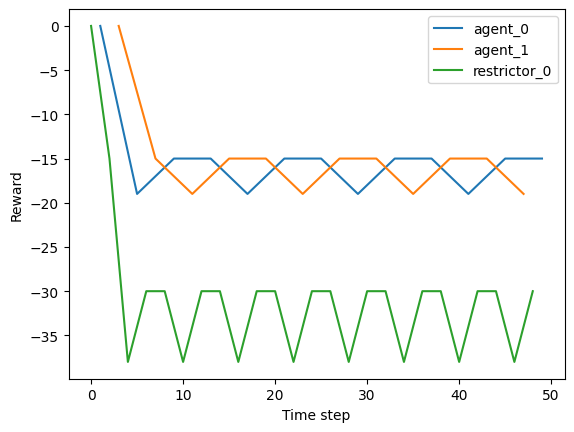

In [146]:
trajectory.groupby('agent')['reward'].plot(legend=True, xlabel='Time step', ylabel='Reward');

In [ ]:
ax, *_ = trajectory.groupby('agent')['action'].plot(style='.', legend=True)
ax.set_yticks(list(route_indices.values()), [edge_path_to_node_path(route, edge_list) for route in route_indices.keys()]);
ax.set_ylabel('Route taken')
ax.set_xlabel('Time step')

## With governance

In [ ]:
number_of_agents = 2

edge_list, edge_indices, edge_latencies, routes, route_list, route_indices = analyze_graph(graph)
number_of_edges = graph.number_of_edges()

agents = {f'agent_{i}': TrafficAgent(routes, route_indices, edge_indices) for i in range (number_of_agents)}
env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)

restrictor = TrafficRestrictor(Box(0, np.inf, shape=(number_of_edges, )), DiscreteVectorActionSpace(Discrete(len(routes))))
wrapper = RestrictionWrapper(env, restrictor, restrictor_reward_fns={'restrictor_0': lambda env, rewards: rewards[env.agent_selection]})

policies = {**{id: agent.act for id, agent in agents.items()}, 'restrictor_0': restrictor.act}

trajectory = play(wrapper, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

In [ ]:
trajectory.groupby('agent')['reward'].plot(legend=True, xlabel='Time step', ylabel='Reward');

In [ ]:
ax, *_ = trajectory[trajectory['agent'] != 'restrictor_0'].groupby('agent')['action'].plot(style='.', legend=True)
ax.set_yticks(list(route_indices.values()), [edge_path_to_node_path(route, edge_list) for route in route_indices.keys()]);
ax.set_ylabel('Route taken')
ax.set_xlabel('Time step')

## With self-learning restrictor

In [160]:
number_of_agents = 2

total_timesteps = 500_000

number_of_edges = graph.number_of_edges()

agents = {f'agent_{i}': TrafficAgent(route_list, source_target_map) for i in range (number_of_agents)}
restrictor = TrafficRestrictor(number_of_edges, number_of_routes,
                               valid_route_restrictions, total_timesteps=total_timesteps)

env = TrafficEnvironment(graph, list(agents), possible_agent_routes, number_of_routes, edge_latencies, route_list, number_of_steps=100)

env = RestrictionWrapper(env, restrictor)

In [ ]:
restricted_history = pd.DataFrame(columns=['episode', 'episode_step', 'agent', 'observation', 'reward', 'action'], index=(range(total_timesteps)))
replay_buffer = ReplayBuffer(state_dim=flatdim(restrictor.observation_space), action_dim=flatdim(restrictor.action_space))

# Do not render during training
env.unwrapped.render_mode = None

current_timestep = 0
current_episode = 0
t = tqdm(total=total_timesteps)

while current_timestep < total_timesteps:
    env.reset()
    current_episode += 1
    current_episode_timestep = 0
    previous_restrictor_observation = None

    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()

        if agent == 'restrictor_0':
            if previous_restrictor_observation is not None:
                restrictor.learn(previous_restrictor_observation, previous_restrictor_action, observation, reward, termination or truncation)

            action = restrictor.act(observation)

            previous_restrictor_observation = observation
            previous_restrictor_action = action
        else:
            action = agents[agent].act(observation)

        if termination or truncation:
            action = None
        else:

        # print(f'{agent=}, {observation=}, {reward=}, {action=}')

            restricted_history.loc[current_timestep] = pd.Series({'episode': current_episode, 
                                               'episode_step': current_episode_timestep, 
                                               'agent': agent,
                                               'observation': observation, 
                                               'reward': reward, 
                                               'action': action}
                                               )
            
            current_timestep += 1
            current_episode_timestep += 1

        env.step(action)

        t.update()

505104it [01:58, 4257.46it/s]


In [157]:
unrestricted_history = pd.DataFrame(columns=['episode', 'episode_step', 'agent', 'observation', 'reward', 'action'], index=(range(total_timesteps)))

# Do not render during training
env.unwrapped.render_mode = None

current_timestep = 0
current_episode = 0
t = tqdm(total=total_timesteps)

while current_timestep < total_timesteps:
    env.reset()
    current_episode += 1
    current_episode_timestep = 0
    previous_restrictor_observation = None

    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()

        if agent == 'restrictor_0':
            action = 14
        else:
            action = agents[agent].act(observation)

        if termination or truncation:
            action = None
        else:
            unrestricted_history.loc[current_timestep] = pd.Series({'episode': current_episode, 
                                               'episode_step': current_episode_timestep, 
                                               'agent': agent,
                                               'observation': observation, 
                                               'reward': reward, 
                                               'action': action}
                                               )
            
            current_timestep += 1
            current_episode_timestep += 1

        env.step(action)

        t.update()

505104it [01:57, 4286.64it/s]:00<?, ?it/s]
504448it [00:57, 8812.36it/s]                            

In [131]:
def smoothen(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size

    if data.ndim == 1:
        return np.convolve(data, kernel, mode='same')
    elif data.ndim == 2:
        return np.array([np.convolve(col, kernel, mode='same') for col in data.T]).T
    else:
        raise NotImplementedError

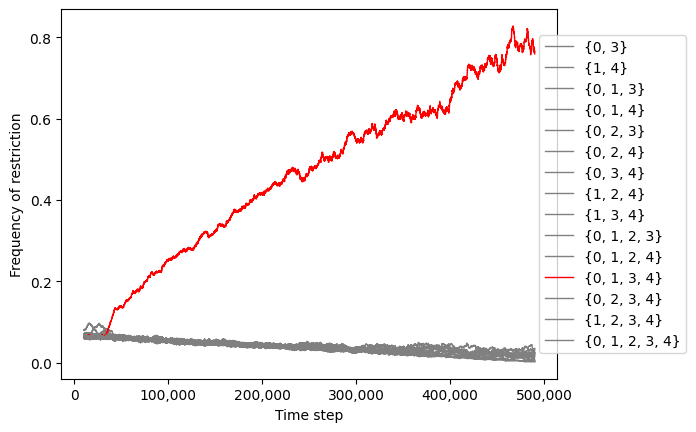

In [168]:
restrictor_actions = restricted_history[restricted_history.agent == 'restrictor_0']['action'].astype(int)
one_hot_restrictor_actions = np.eye(len(valid_edge_restrictions))[restrictor_actions.to_numpy().reshape(-1)]

fig, ax = plt.subplots()

data = pd.DataFrame(smoothen(one_hot_restrictor_actions, kernel_size=5_000), index=restrictor_actions.index, columns=valid_edge_restrictions)
lines = ax.plot(data.iloc[5000:-5000], color='gray', lw=1)
# lines = ax.plot(restrictor_history.index, smoothen(one_hot_restrictor_actions, kernel_size=5_000), color='gray', lw=1)
lines[11].set_color('red')
ax.legend(labels=valid_edge_restrictions, loc='center left', bbox_to_anchor=(0.95, 0.5))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Frequency of restriction')
ax.set_xlabel('Time step')

fig.savefig('traffic-result-actions.pdf', bbox_inches='tight')

In [166]:
unrestricted_social_welfare = unrestricted_history[unrestricted_history['agent'] == 'restrictor_0']['reward']
unrestricted_data = pd.Series(smoothen(unrestricted_social_welfare.to_numpy().squeeze(), kernel_size=1000), index=unrestricted_social_welfare.index)

restricted_social_welfare = restricted_history[restricted_history.agent == 'restrictor_0']['reward']
restricted_data = pd.Series(smoothen(restricted_social_welfare.to_numpy().squeeze(), kernel_size=1000), index=restricted_social_welfare.index)

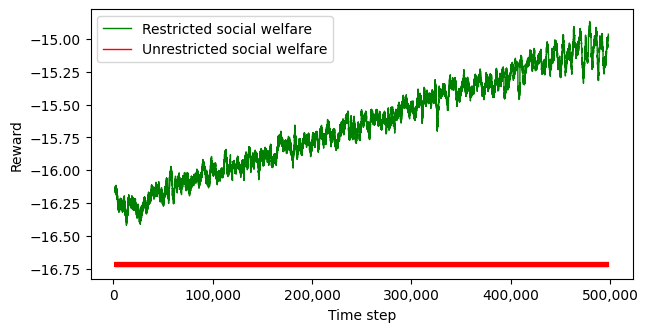

In [170]:
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(restricted_data[1000:-1000] / 2, lw=1, color='green', label='Restricted social welfare')
ax.plot(unrestricted_data[1000:-1000] / 2, lw=1, color='red', label='Unrestricted social welfare')

ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Reward')
ax.set_xlabel('Time step');
ax.legend(loc='upper left')
# ax.set_ylim(-1, -14)

fig.savefig('traffic-result-reward.pdf', bbox_inches='tight')


<Axes: >

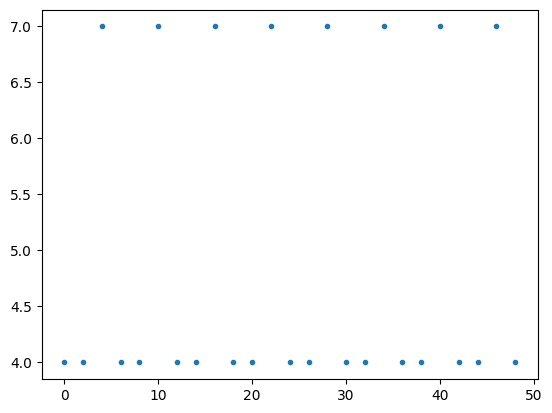

In [20]:
policies = {**{id: agent.act for id, agent in agents.items()}, 'restrictor_0': restrictor.act}

trajectory = play(env, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

trajectory[trajectory['agent'] == 'restrictor_0']['action'].astype(int).plot(style='.')